In [1]:
from datasets import load_dataset, concatenate_datasets, DatasetDict

/opt/conda/envs/nesy-concept-drift-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from datasets import get_dataset_config_names

print(get_dataset_config_names("flwrlabs/celeba"))

['img_align+identity+attr']


In [4]:
ds = load_dataset("flwrlabs/celeba")

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
        num_rows: 162770
    })
    valid: Dataset({
        features: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'H

In [6]:
def compute_sorted_counts(ds, split):
    df = ds[split].to_pandas()
    attribute_columns = [attr for attr in ds[split].features if attr not in ['image', 'celeb_id']]

    male_df = df[df['Male'] == 1]
    female_df = df[df['Male'] == 0]

    male_counts = male_df[attribute_columns].sum().astype(int)
    female_counts = female_df[attribute_columns].sum().astype(int)

    diff = (male_counts - female_counts).abs()

    counts_df = pd.DataFrame({
        'Attribute': attribute_columns,
        'Male': male_counts,
        'Female': female_counts,
        'AbsGap': diff
    }).sort_values(by='AbsGap', ascending=False)

    return counts_df

# Bar plot sorted by absolute gender gap
def plot_sorted_counts(ds, split):
    counts_df = compute_sorted_counts(ds, split)
    counts_df.set_index("Attribute", inplace=True)

    ax = counts_df[['Male', 'Female']].plot(
        kind='bar', figsize=(16, 6),
        title=f"Attributes Sorted by Gender Gap – '{split}' Split"
    )
    ax.set_ylabel("Count of 'True' Values")
    ax.set_xlabel("Attributes (sorted by |Male - Female|)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Compute True counts per gender
def compute_counts(ds, split):
    df = ds[split].to_pandas()
    attribute_columns = [attr for attr in ds[split].features if attr not in ['image', 'celeb_id']]

    male_df = df[df['Male'] == 1]
    female_df = df[df['Male'] == 0]

    male_counts = male_df[attribute_columns].sum().astype(int)
    female_counts = female_df[attribute_columns].sum().astype(int)

    counts_df = pd.DataFrame({
        'Attribute': attribute_columns,
        'Male': male_counts,
        'Female': female_counts
    })

    return counts_df

# Bar plot of True counts per gender
def plot_counts(ds, split):
    counts_df = compute_counts(ds, split)
    counts_df.set_index("Attribute", inplace=True)
    counts_df.sort_index(inplace=True)

    ax = counts_df.plot(
        kind='bar', figsize=(16, 6),
        title=f"Attribute True Counts in '{split}' Split"
    )
    ax.set_ylabel("Number of Samples")
    ax.set_xlabel("Attributes")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

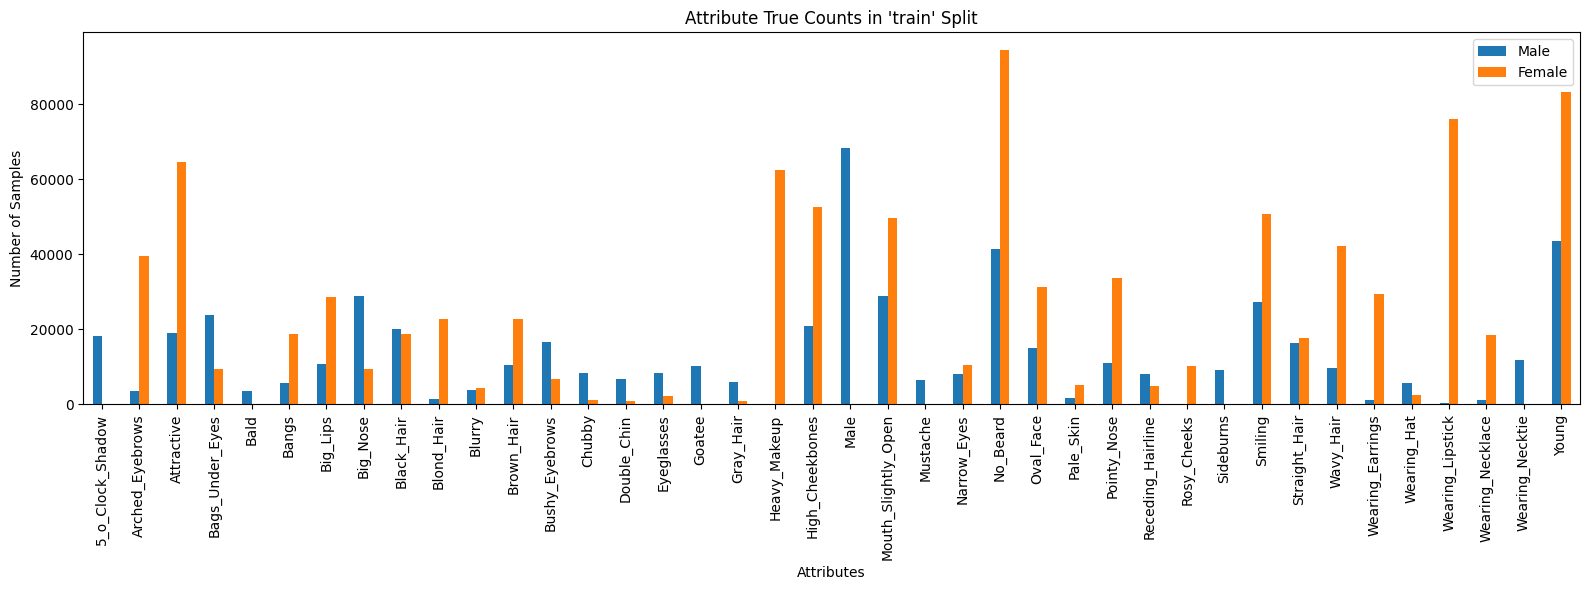

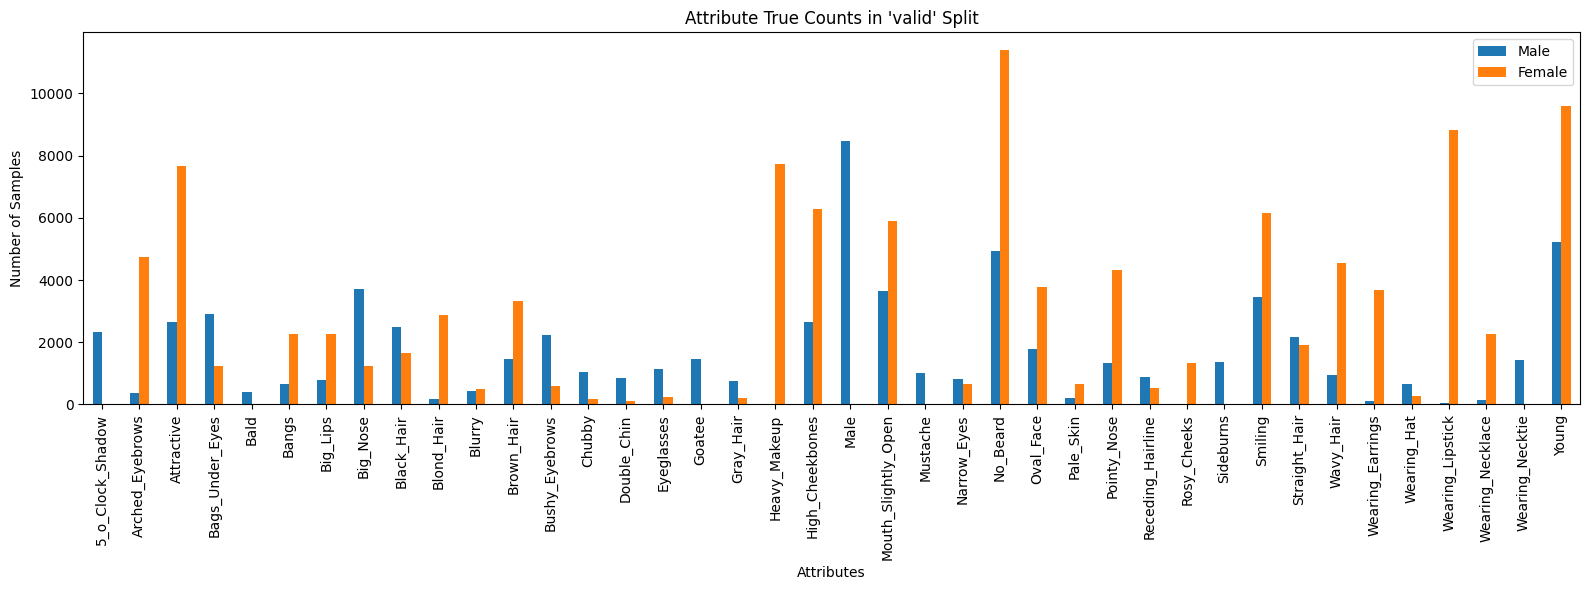

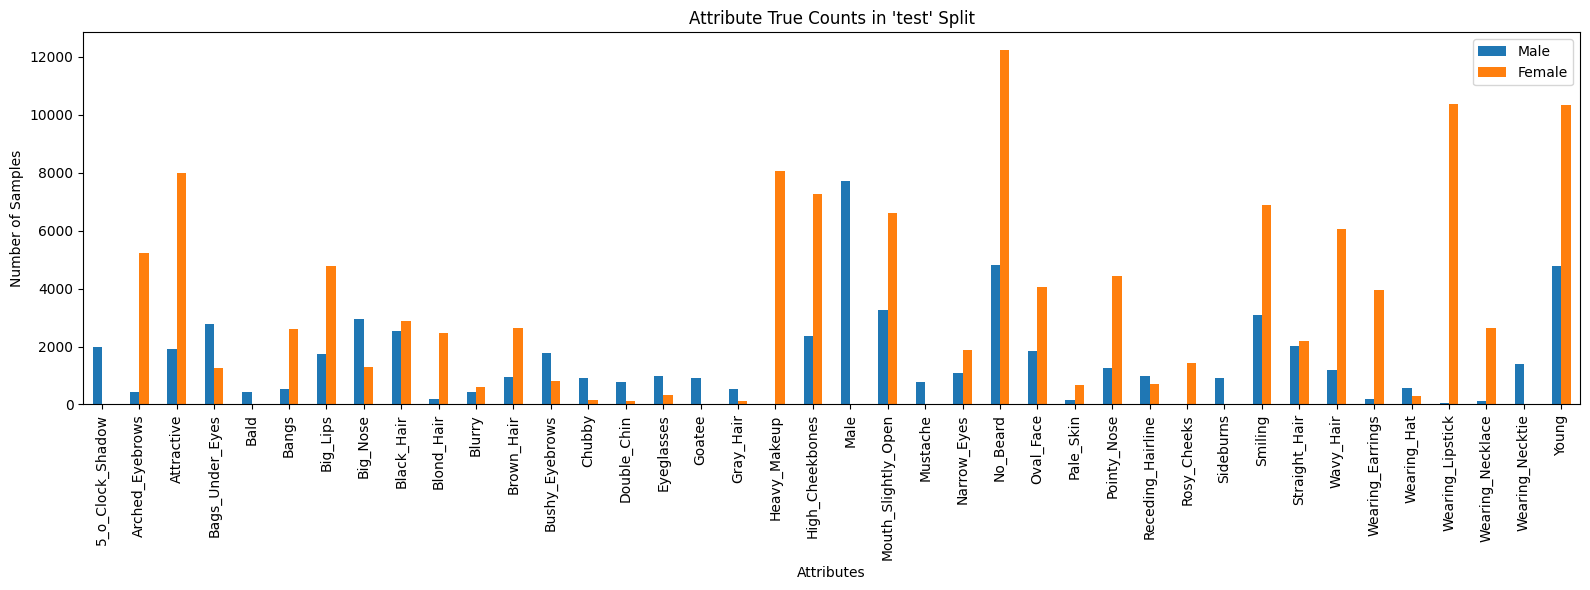

In [7]:
for split in ['train', 'valid', 'test']:
    plot_counts(ds, split)

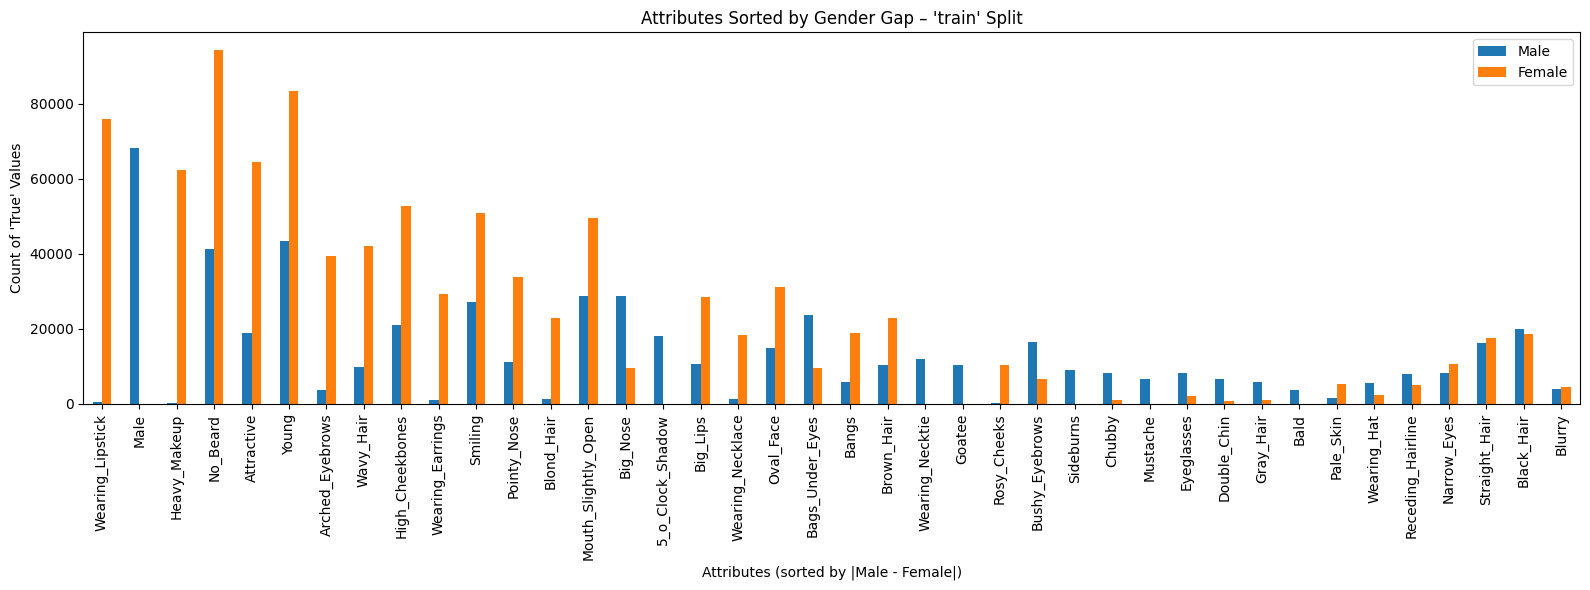

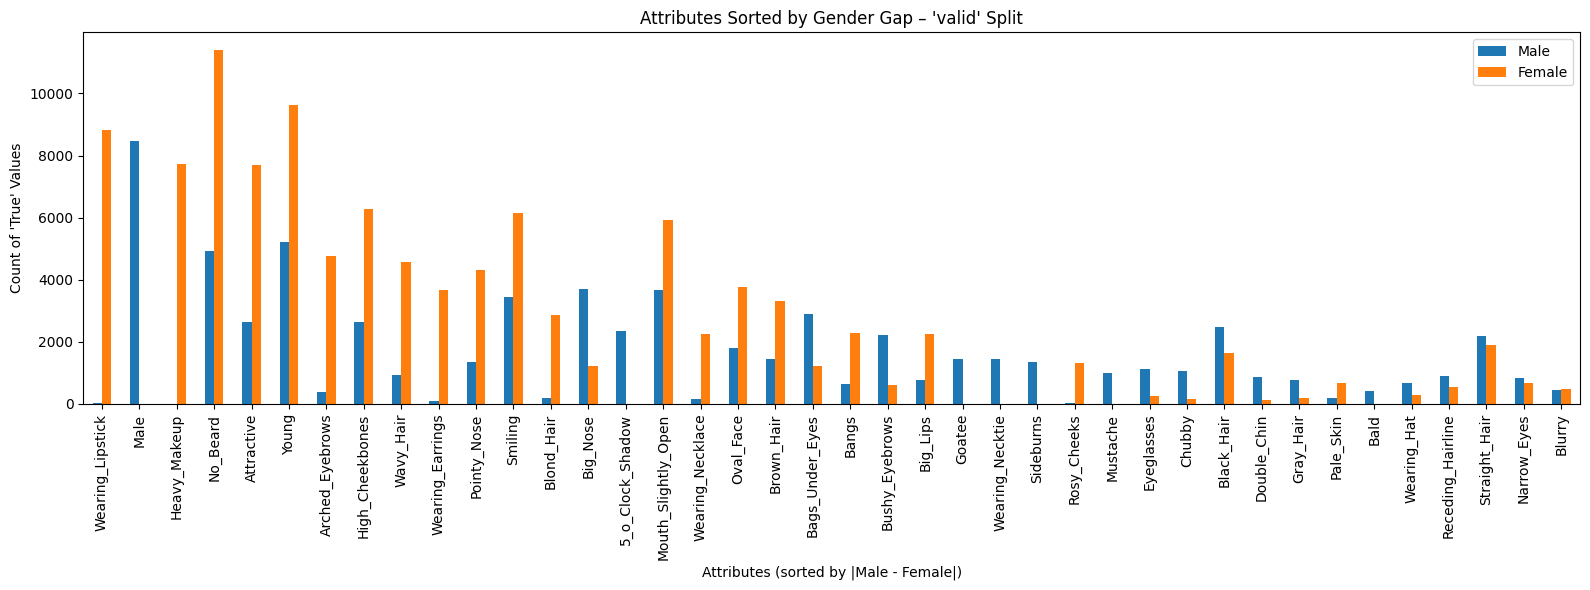

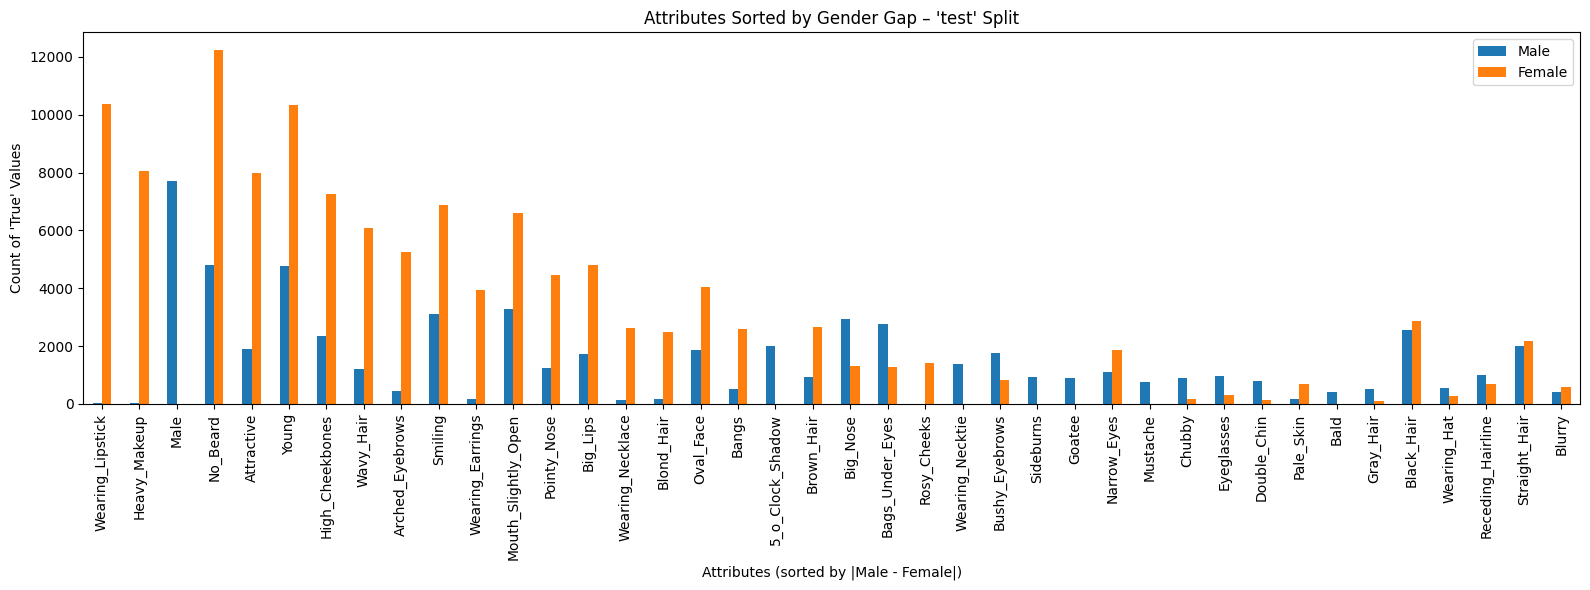

In [8]:
for split in ['train', 'valid', 'test']:
    plot_sorted_counts(ds, split)

In [9]:
# Parameters
drift_gender = 1  # 1 = Male, 0 = Female
drift_attribute = "Smiling"
drift_attribute_value = 1  # 1 = True, 0 = False

In [10]:
# Function to extract drift samples and remove them from a dataset
def split_drift(dataset, drift_gender, drift_attribute, drift_attribute_value):
    def is_drift(example):
        return example["Male"] == drift_gender and example[drift_attribute] == drift_attribute_value
    def is_not_drift(example):
        return not is_drift(example)

    drift_subset = dataset.filter(is_drift)
    remaining_subset = dataset.filter(is_not_drift)
    return remaining_subset, drift_subset

In [11]:
# Split each part
train_clean, train_drift = split_drift(ds["train"], drift_gender, drift_attribute, drift_attribute_value)
valid_clean, valid_drift = split_drift(ds["valid"], drift_gender, drift_attribute, drift_attribute_value)
test_clean, test_drift = split_drift(ds["test"], drift_gender, drift_attribute, drift_attribute_value)

In [12]:
drift_split = concatenate_datasets([train_drift, valid_drift, test_drift])

In [13]:
# Rebuild dataset dictionary
new_ds = DatasetDict({
    "train": train_clean,
    "valid": valid_clean,
    "test": test_clean,
    "drift": drift_split
})

In [14]:
new_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
        num_rows: 135511
    })
    valid: Dataset({
        features: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'H

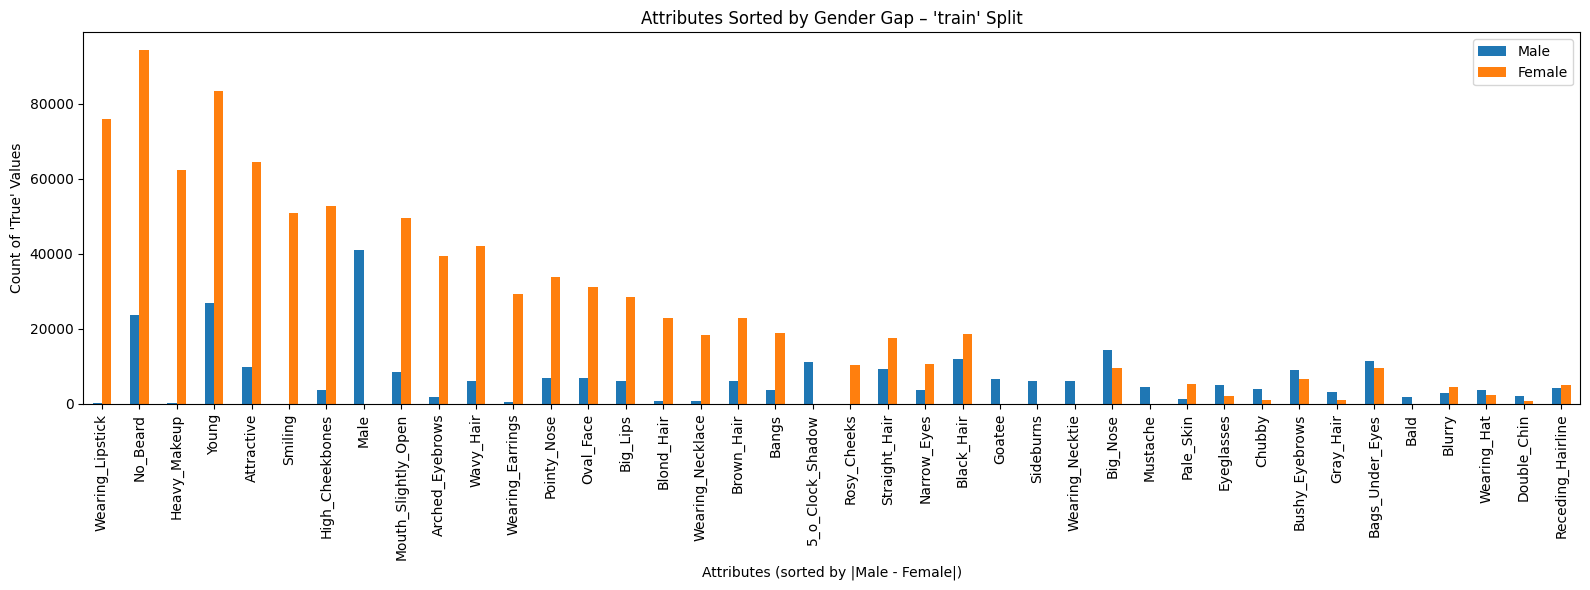

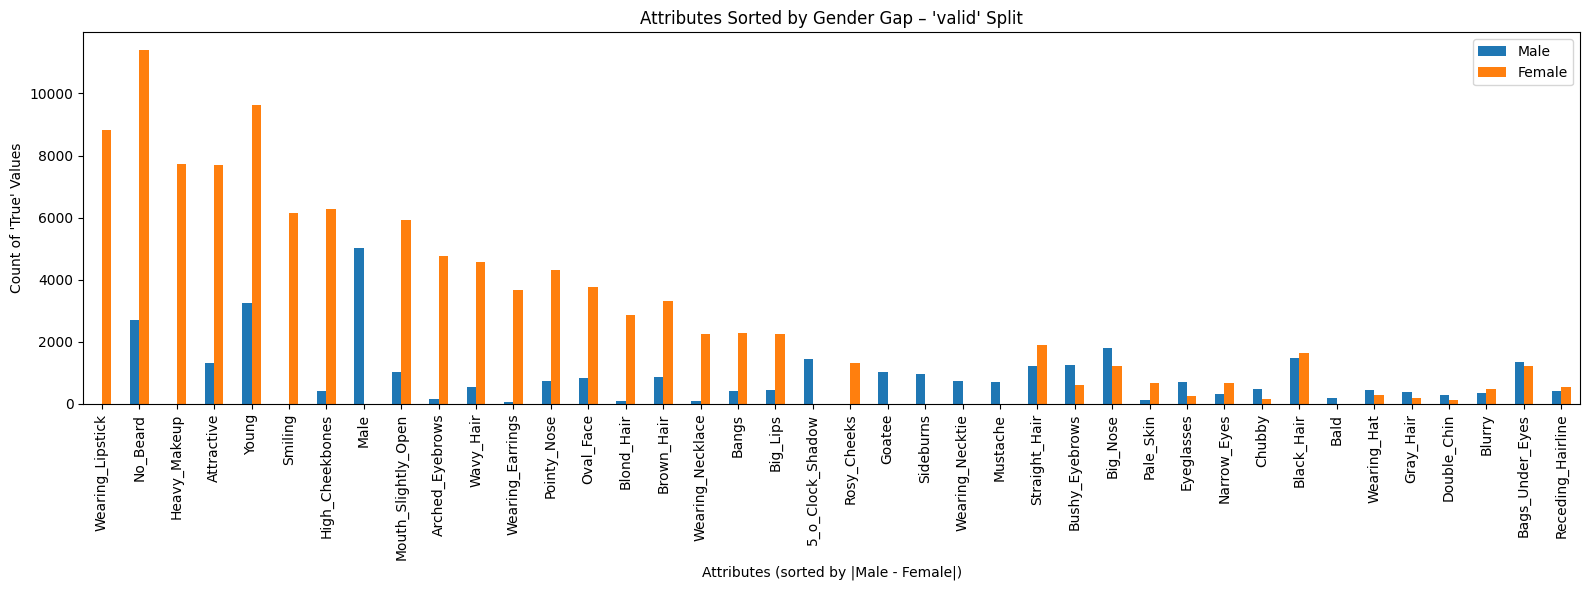

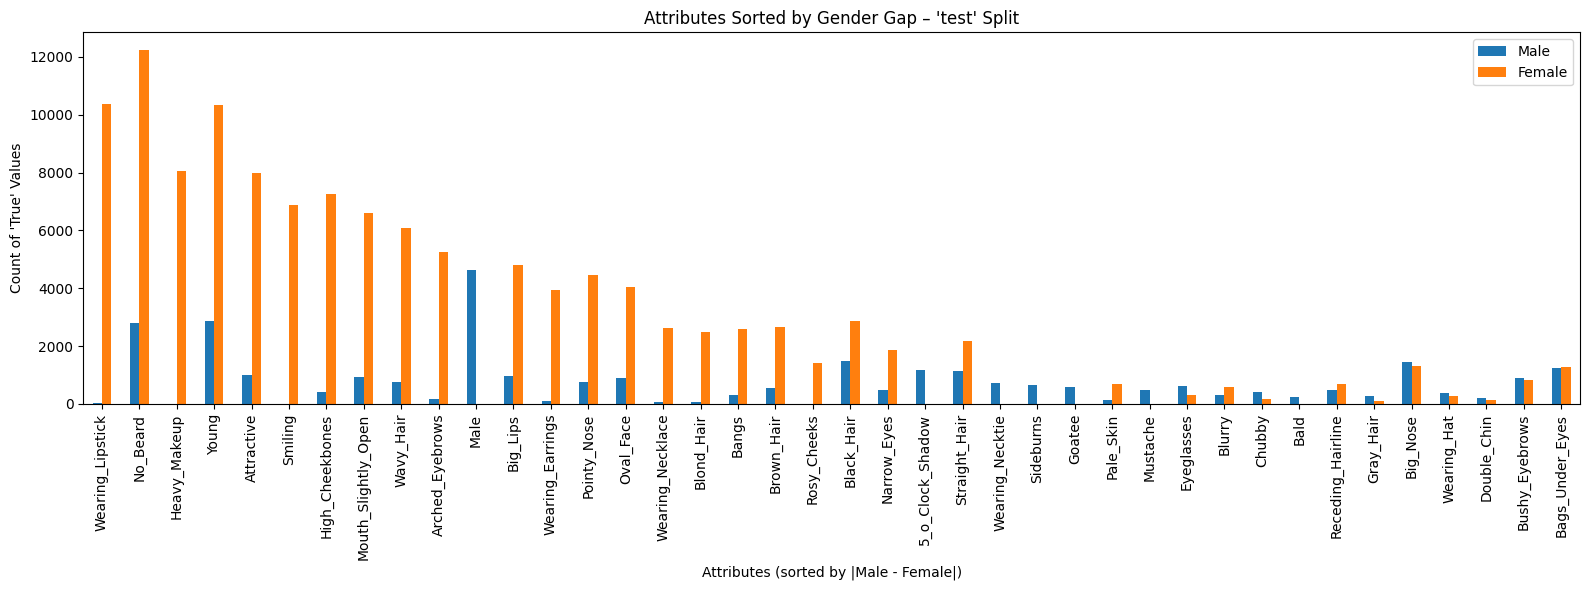

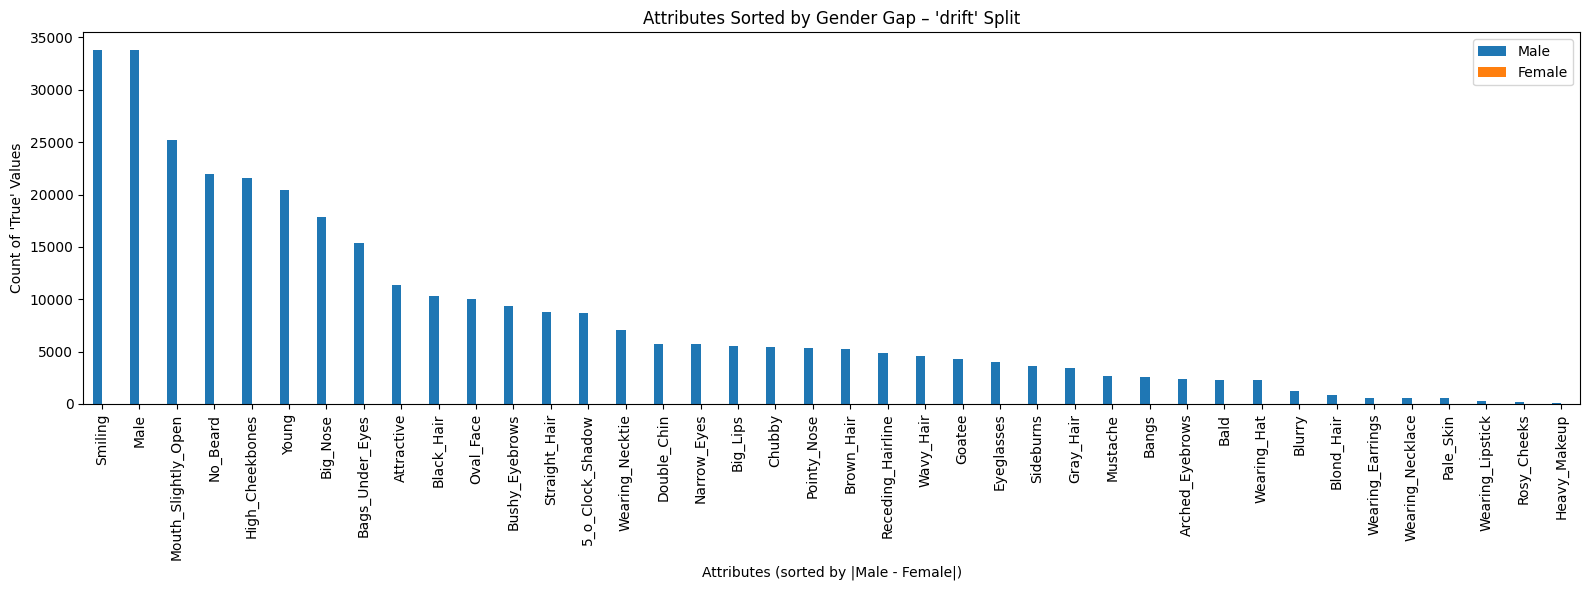

In [17]:
for split in ['train', 'valid', 'test', 'drift']:
    plot_sorted_counts(new_ds, split)

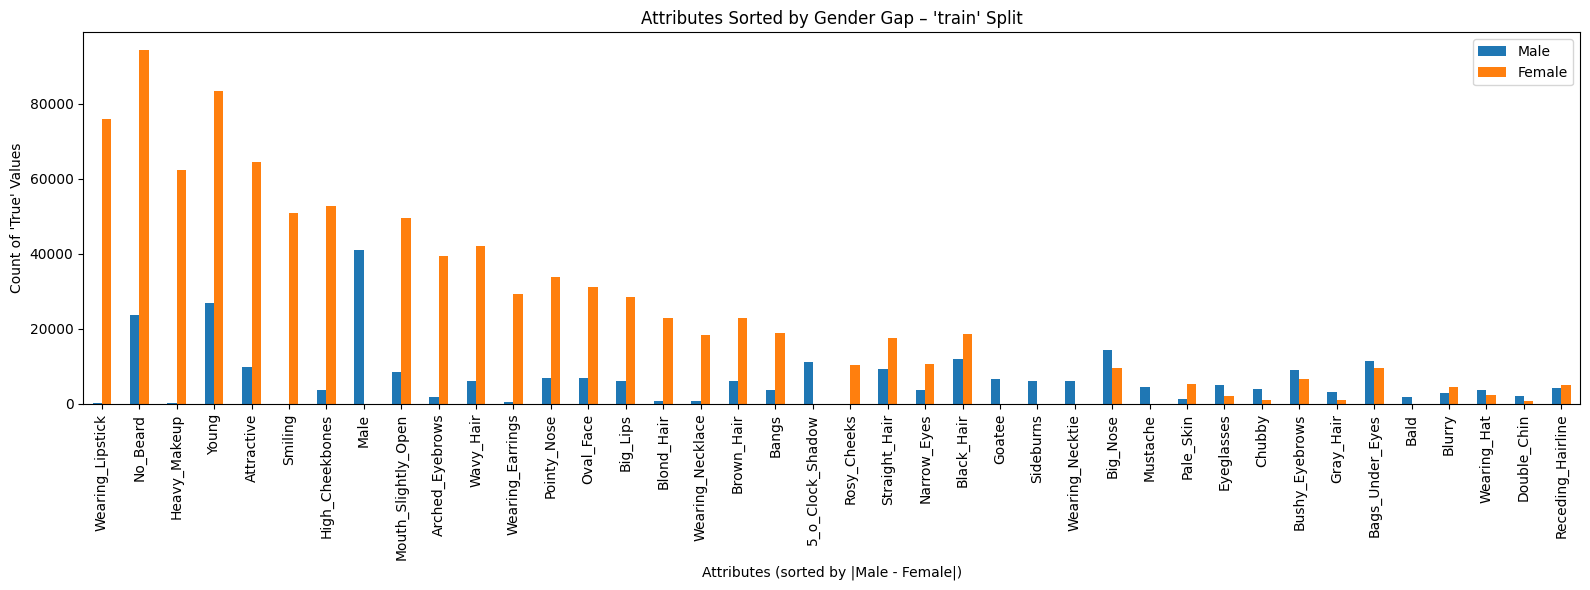

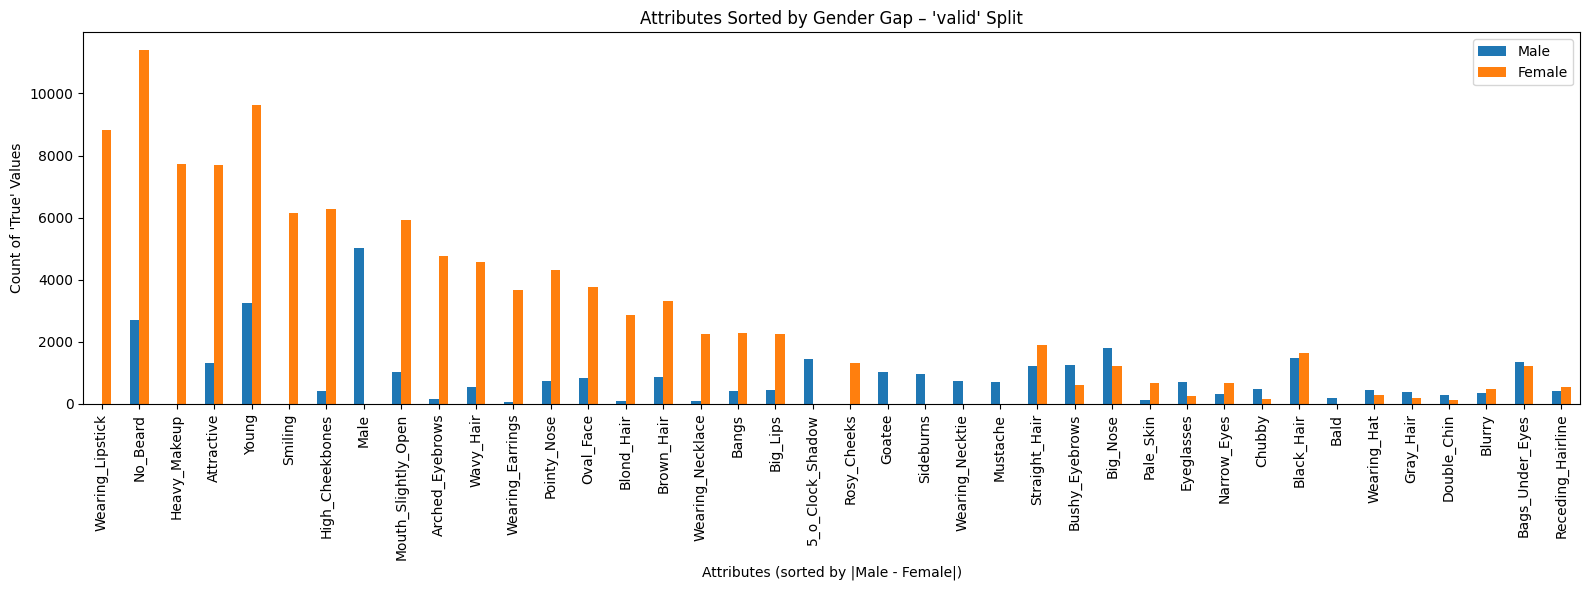

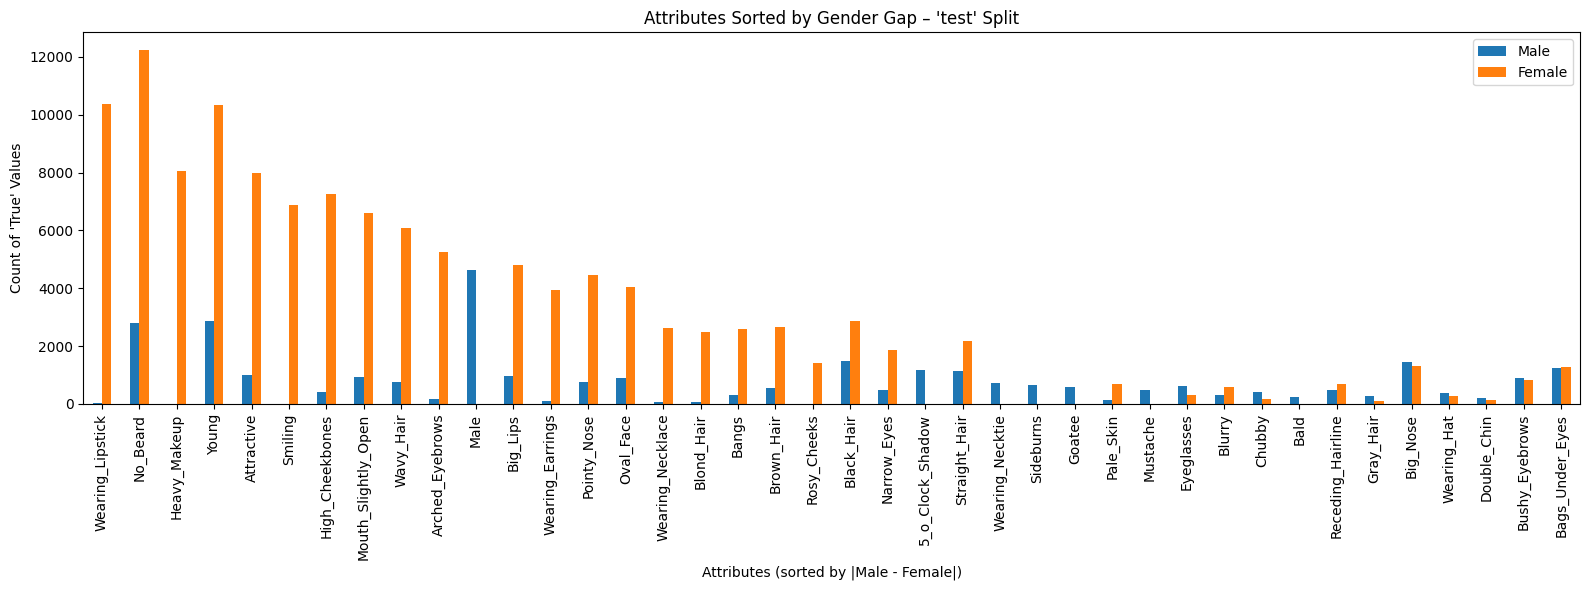

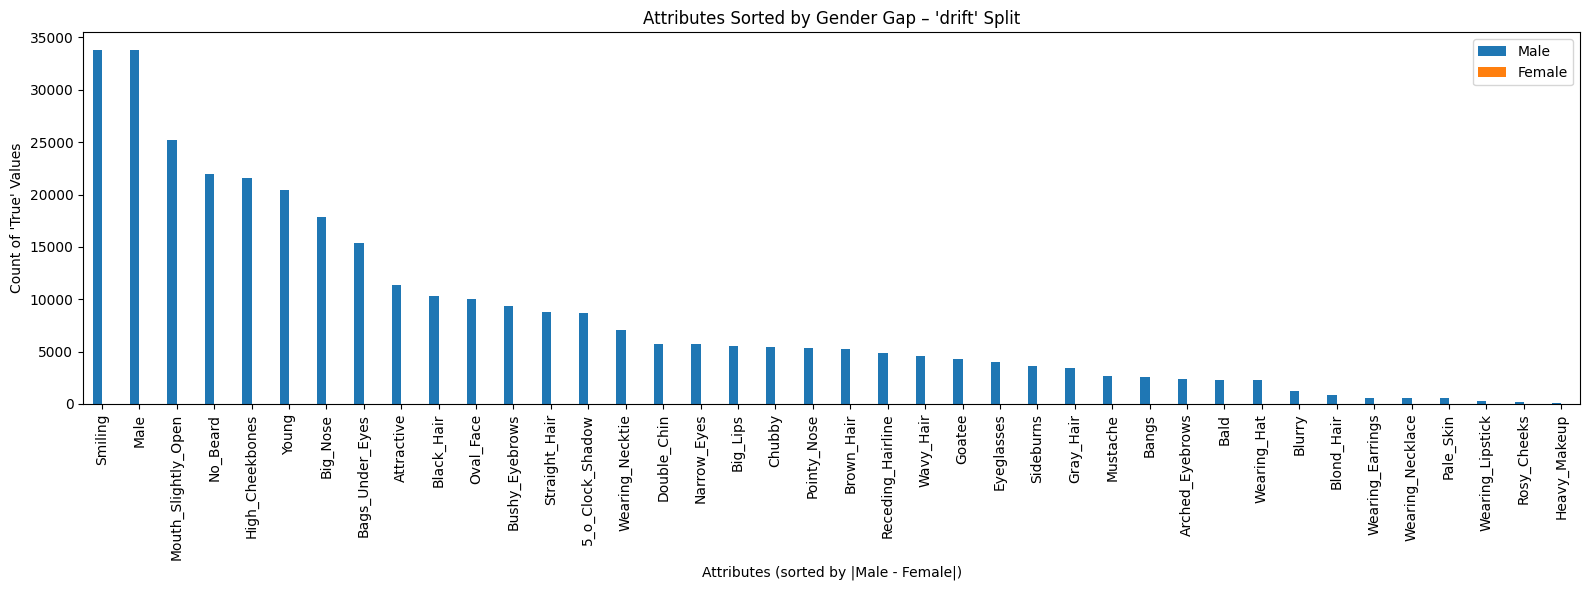

In [18]:
for split in ['train', 'valid', 'test', 'drift']:
    plot_sorted_counts(new_ds, split)

In [21]:
if drift_gender == 1:
    drifted_gender_name = "male"
else:
    drifted_gender_name = "female"
    
if drift_attribute_value == 1:
    drift_attribute_desc = drift_attribute
else:
    drift_attribute_desc = f"not_{drift_attribute}"
    
dataset_folder_name = f"CelebA_{drifted_gender_name}_{drift_attribute_desc}"

new_ds.save_to_disk(f"data/{dataset_folder_name}")

Saving the dataset (4/4 shards): 100%|██████████| 33798/33798 [00:08<00:00, 3984.30 examples/s]
